In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import statsmodels.api as sm
import glob
from pathlib import Path
import json
import os

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

In [94]:
def get_datadir_from_config(config_file='config.json'):

    config_path = Path(config_file)
    if not config_path.exists():
        raise FileNotFoundError("Missing config.json. Please create one with your local data path.")

    with open(config_path, 'r') as f: 
        config = json.load(f)

    datadir = Path(config['data_path'])
    return datadir
def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files
def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
def get_neuron_profile(file_path):
    """
    Extracts neuron tuning profiles from a single HDF5 session file.

    Parameters:
    - file_path: str, path to the .h5 file

    Returns:
    - neuron_profile: pd.DataFrame with tuning betas, p-values, and metadata
    """
    # Load firing rates and metadata
    fr_CdN = pull_from_h5(file_path, 'CdN_zFR')
    fr_OFC = pull_from_h5(file_path, 'OFC_zFR')
    firing_rates = np.concatenate([fr_CdN, fr_OFC], axis=2)

    u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'),
                              pull_from_h5(file_path, 'OFC_u_names')], axis=0)

    n_CdN = fr_CdN.shape[2]
    n_OFC = fr_OFC.shape[2]
    brain_areas = np.concatenate([np.zeros(n_CdN), np.ones(n_OFC)]).astype(int)

    u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'),
                                  pull_from_h5(file_path, 'OFC_locations')], axis=0)

    bhv = pd.read_hdf(file_path, key='bhv')
    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    # Trial selection
    trials2keep = bhv['n_sacc'] > 0
    bhv = bhv.loc[trials2keep]
    firing_rates = firing_rates[trials2keep, :, :]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Best-choice trials
    mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
    trial_profile = bhv[mask].reset_index()
    firing_single_best = firing_rates[mask.values, :, :]

    mean_FR = firing_single_best.mean(axis=1)  # shape: (n_trials, n_units)
    n_units = mean_FR.shape[1]

    # GLM design matrix
    df = pd.DataFrame({
        'value': trial_profile['ch_val'].values,
        'state': trial_profile['state'].values
    })
    state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
    df = pd.concat([df, state_dummies], axis=1)

    df['state_value_1'] = df['value'] * df['state_1']
    df['state_value_2'] = df['value'] * df['state_2']
    df['state_value_3'] = df['value'] * df['state_3']

    tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
                   'state_value_1', 'state_value_2', 'state_value_3']
    X = df[tuning_cols].astype(int)
    X = sm.add_constant(X)

    # Fit GLM for each neuron
    beta_dict = {col: [] for col in X.columns}
    pval_dict = {col: [] for col in X.columns}

    for i in range(n_units):
        y = mean_FR[:, i]
        model = sm.OLS(y, X).fit()
        for col in X.columns:
            beta_dict[col].append(model.params[col])
            pval_dict[col].append(model.pvalues[col])

    # Assemble neuron profile
    neuron_profile = pd.DataFrame({
        'neuron': u_names,
        'brain_area': brain_areas,
        'lateral': u_locations[:, 0],
        'depth': u_locations[:, 1],
        **{f'{col}_beta': beta_dict[col] for col in X.columns},
        **{f'{col}_pval': pval_dict[col] for col in X.columns}
    })

    return neuron_profile
def get_coding_type(neuron_profile, p_thresh=0.05):
    """Classify neurons based on their coding type using p-value thresholds.
    
    Parameters:
    neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with p-values.
    p_thresh (float): Significance threshold for p-values.
    Returns:
    
    pd.DataFrame: Updated DataFrame with a new 'coding_type' column.
    """
    
    # State coding: any state term is significant
    state_coding = (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )

    # Value coding: value term is significant, but not state coding
    val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)

    # state_value coding: any interaction term is significant, but not pure value coding
    state_val_coding = (
        (neuron_profile['state_value_1_pval'] < p_thresh) |
        (neuron_profile['state_value_2_pval'] < p_thresh) |
        (neuron_profile['state_value_3_pval'] < p_thresh)
    ) & (~val_coding)

    # Refine state coding: exclude neurons already classified as state_val_coding
    state_coding = state_coding & (~state_val_coding)
    
    neuron_profile['coding_type'] = 'none'  # default
    neuron_profile.loc[state_coding, 'coding_type'] = 'state'
    neuron_profile.loc[val_coding, 'coding_type'] = 'value'
    neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'
    
    return neuron_profile
def get_value_correlation(row):
    """
    Determine the value correlation of a neuron based on its coding type and beta coefficients.
    
    Parameters:
    row (pd.Series): A row from the neuron_profile DataFrame.
    only_significant (bool): If True, only consider the primary coding type for correlation.
    
    Returns:
    int or str: 1 for positive correlation, -1 for negative correlation, 'none' if no significant coding.
    """
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
            return 'none'


In [95]:
data_dir = get_datadir_from_config()
data_files = find_h5_files(data_dir)

OFC_profiles = []
CdN_profiles = []

for f in data_files:
    neuron_profile = get_neuron_profile(f)
    neuron_profile['session'] = os.path.basename(f)
    neuron_profile['animal'] = neuron_profile['session'].str[0]
    
    neuron_profile = get_coding_type(neuron_profile, p_thresh=0.05)
    neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)
    neuron_profile['value_correlation'] = (
    neuron_profile['value_correlation'].replace('none', 0.0).infer_objects(copy=False)
    )
     
    OFC_mask = neuron_profile['brain_area'] == 1
    CdN_mask = neuron_profile['brain_area'] == 0
    OFC_neurons = neuron_profile[OFC_mask]
    CdN_neurons = neuron_profile[CdN_mask]
    
    OFC_profiles.append(OFC_neurons)
    CdN_profiles.append(CdN_neurons)

OFC_profiles = pd.concat(OFC_profiles, ignore_index=True)
CdN_profiles = pd.concat(CdN_profiles, ignore_index=True)

C:\Users\krgyk\AppData\Local\Temp\ipykernel_20192\4075940029.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  neuron_profile['value_correlation'].replace('none', 0.0).infer_objects(copy=False)
C:\Users\krgyk\AppData\Local\Temp\ipykernel_20192\4075940029.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  neuron_profile['value_correlation'].replace('none', 0.0).infer_objects(copy=False)
C:\Users\krgyk\AppData\Local\Temp\ipykernel_20192\4075940029.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be

In [96]:
ani_d_OFC_mask = OFC_profiles['animal'] == 'D'
ani_d_CdN_mask = CdN_profiles['animal'] == 'D'

ani_k_OFC_mask = OFC_profiles['animal'] == 'K'
ani_k_CdN_mask = CdN_profiles['animal'] == 'K'


ani_d_OFC = OFC_profiles[ani_d_OFC_mask]
ani_d_CdN = CdN_profiles[ani_d_CdN_mask]

ani_d_OFC.head()

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,session,animal,coding_type,value_correlation
0,b'D20231219_Rec05_OFC_u2',1,88.272680,-5.395501,0.064782,-0.021819,-0.103674,0.138792,0.029664,0.022733,...,0.024518,0.003853,0.531005,0.104626,0.005207,0.764355,D20231219_Rec05.h5,D,state_value,-1.0
1,b'D20231219_Rec05_OFC_u3',1,8.351528,38.571753,0.080885,-0.027055,-0.018384,0.081307,0.017962,-0.001595,...,0.707094,0.110515,0.721306,0.914651,0.041578,0.714750,D20231219_Rec05.h5,D,value,-1.0
2,b'D20231219_Rec05_OFC_u6',1,109.002712,77.172002,0.192756,-0.064685,0.088334,0.139525,-0.035103,-0.033946,...,0.080672,0.008104,0.499541,0.027451,0.003667,0.343386,D20231219_Rec05.h5,D,state_value,-1.0
3,b'D20231219_Rec05_OFC_u7',1,-14.246603,105.280740,0.021504,-0.007595,0.021290,0.081391,-0.081177,-0.011350,...,0.636566,0.082860,0.080409,0.407720,0.030775,0.016956,D20231219_Rec05.h5,D,state_value,1.0
4,b'D20231219_Rec05_OFC_u9',1,84.579478,104.039762,0.098393,-0.032212,0.094129,0.119543,-0.115279,-0.025776,...,0.147894,0.077438,0.085219,0.192633,0.014199,0.035454,D20231219_Rec05.h5,D,value,-1.0


In [97]:
for f in data_files:
    print(f)
file_path = data_files[0]
print(f'Using file: {os.path.basename(file_path)}')

D:\Projects\rotation_project\data2analyze\D20231219_Rec05.h5
D:\Projects\rotation_project\data2analyze\D20231221_Rec06.h5
D:\Projects\rotation_project\data2analyze\D20231224_Rec07.h5
D:\Projects\rotation_project\data2analyze\D20231227_Rec08.h5
D:\Projects\rotation_project\data2analyze\K20240707_Rec06.h5
D:\Projects\rotation_project\data2analyze\K20240710_Rec07.h5
D:\Projects\rotation_project\data2analyze\K20240712_Rec08.h5
D:\Projects\rotation_project\data2analyze\K20240715_Rec09.h5
Using file: D20231219_Rec05.h5


In [98]:
neuron_profile = get_neuron_profile(file_path)
neuron_profile = get_coding_type(neuron_profile)
neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)

In [99]:
neuron_profile

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,const_pval,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,coding_type,value_correlation
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,-0.209555,0.073203,-0.107952,-0.002444,-0.099159,0.022040,...,2.248013e-11,2.077736e-14,6.079816e-02,9.673977e-01,0.094160,2.078615e-01,9.986050e-01,0.005114,value,1.0
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,-0.098001,0.031881,-0.026236,0.009821,-0.081586,0.009982,...,5.989415e-05,1.758840e-05,5.631881e-01,8.351927e-01,0.081044,4.696540e-01,6.971981e-01,0.056862,value,1.0
2,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.003928,-0.001495,-0.023993,0.072596,-0.052531,0.013681,...,9.104573e-01,8.879737e-01,7.135640e-01,2.858809e-01,0.434968,4.914496e-01,6.551969e-01,0.241084,none,none
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,0.107467,-0.035350,0.017201,0.091929,-0.001663,-0.009664,...,1.709934e-03,6.889923e-04,7.876026e-01,1.666495e-01,0.979803,6.187850e-01,8.002154e-02,0.649476,value,-1.0
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,0.586666,-0.184180,0.361736,0.341579,-0.116649,-0.118231,...,1.669017e-73,3.629804e-77,1.035456e-11,5.820229e-10,0.030000,3.192019e-13,1.375211e-09,0.039481,state_value,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,b'D20231219_Rec05_OFC_u565',1,-0.692354,3792.714077,0.063593,-0.028176,0.098272,-0.004537,-0.030143,0.009741,...,1.556031e-02,4.342394e-04,4.556874e-02,9.291789e-01,0.550644,5.140540e-01,5.479628e-01,0.064802,state,1.0
783,b'D20231219_Rec05_OFC_u566',1,-11.716311,3752.252066,-0.020885,0.001855,-0.110876,0.123807,-0.033816,0.007843,...,4.901320e-01,8.400570e-01,5.058175e-02,3.590928e-02,0.561775,6.488797e-01,7.250216e-03,0.020785,state_value,-1.0
784,b'D20231219_Rec05_OFC_u567',1,105.845457,3796.256082,-0.002208,0.001986,-0.061156,0.060005,-0.001058,0.008939,...,9.343472e-01,8.073163e-01,2.230657e-01,2.504370e-01,0.983651,5.580381e-01,2.272535e-01,0.452503,none,none
785,b'D20231219_Rec05_OFC_u568',1,88.446736,3801.910258,0.053250,-0.025483,-0.081495,-0.037843,0.172588,0.000668,...,1.219918e-02,8.401741e-05,4.019925e-02,3.590590e-01,0.000027,9.558177e-01,1.802680e-01,0.445356,state,1.0


In [114]:
OFC_mask = neuron_profile['brain_area'] == 1
CdN_mask = neuron_profile['brain_area'] == 0

OFC_profile = neuron_profile[OFC_mask]
CdN_profile = neuron_profile[CdN_mask]

OFC_profile.sort_values('depth', inplace=True)
OFC_profile = OFC_profile.reset_index(drop=True)

CdN_profile.sort_values('depth', inplace=True)
CdN_profile = CdN_profile.reset_index(drop=True)

C:\Users\krgyk\AppData\Local\Temp\ipykernel_20192\1876711145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OFC_profile.sort_values('depth', inplace=True)
C:\Users\krgyk\AppData\Local\Temp\ipykernel_20192\1876711145.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CdN_profile.sort_values('depth', inplace=True)


C:\Users\krgyk\AppData\Local\Temp\ipykernel_20192\2181401122.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  OFC_profile['value_correlation'].replace('none', 0.0).infer_objects(copy=False)


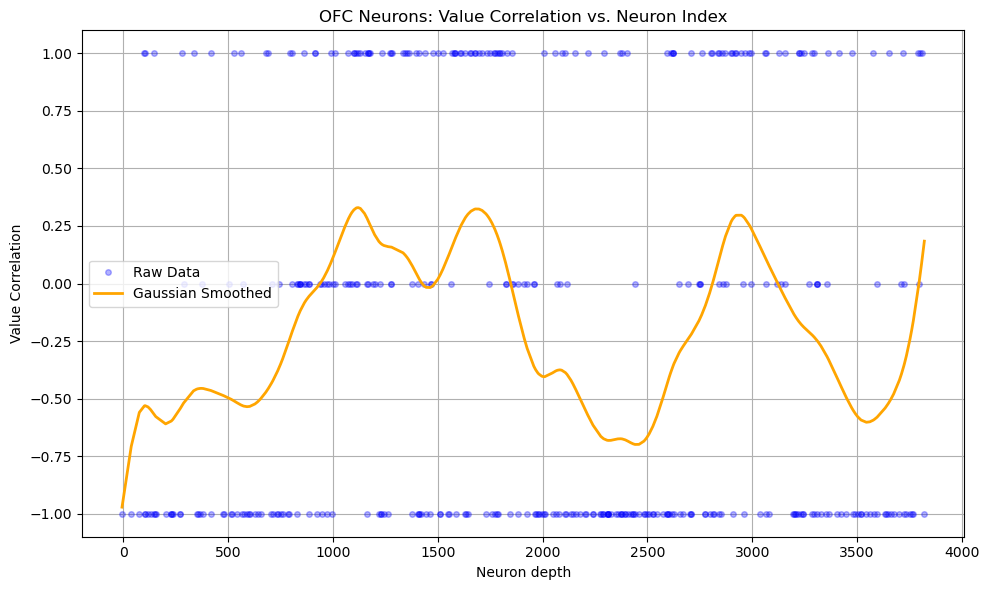

In [116]:
from statsmodels.nonparametric.kernel_regression import KernelReg

OFC_profile['value_correlation'] = (
    OFC_profile['value_correlation'].replace('none', 0.0).infer_objects(copy=False)
)

x = OFC_profile['depth'].values.astype(float)
y = OFC_profile['value_correlation'].values.astype(float)

sigma = 80  # Bandwidth for Gaussian kernel
kr = KernelReg(endog=[y], exog=[x], var_type='c', bw=[sigma])

m_hat, _ = kr.fit(x)
p_plus = (m_hat + 1.0) / 2.0

smoothed_OFC = m_hat




plt.figure(figsize=(10, 6))
plt.plot(OFC_profile['depth'], OFC_profile['value_correlation'], 'o', alpha=0.3, label='Raw Data', color='blue', markersize=4)
plt.plot(OFC_profile['depth'], smoothed_OFC, '-', label='Gaussian Smoothed', color='orange', linewidth=2)
plt.title('OFC Neurons: Value Correlation vs. Neuron Index')
plt.xlabel('Neuron depth')
plt.ylabel('Value Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

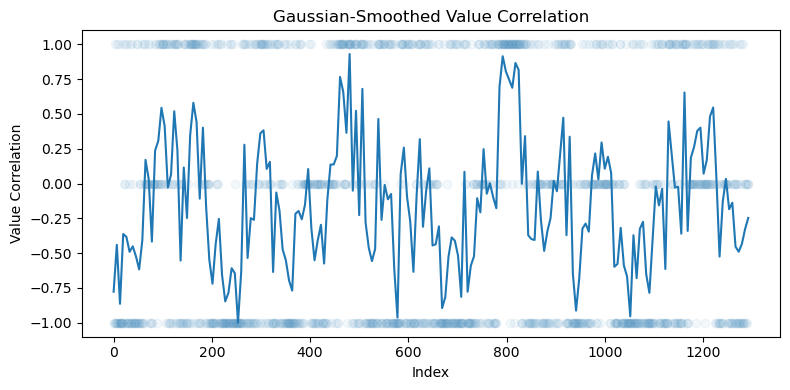

In [102]:
from scipy.stats import norm

x_raw = animal_d_OFC.index.values.astype(float)
y_raw = animal_d_OFC['value_correlation'].values.astype(float)

x_smooth = np.linspace(x_raw.min(), x_raw.max(), 200)  # Smooth x-axis
bandwidth = 2  # Controls the width of the Gaussian kernel

y_smooth = []
for x0 in x_smooth:
    weights = norm.pdf(x_raw, loc=x0, scale=bandwidth)
    weights /= weights.sum()
    y_smooth.append(np.sum(weights * y_raw))

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=x_smooth, y=y_smooth)
plt.scatter(x_raw, y_raw, alpha=0.05, label='Raw Data')
plt.xlabel('Index')
plt.ylabel('Value Correlation')
plt.title('Gaussian-Smoothed Value Correlation')
plt.tight_layout()
plt.show()

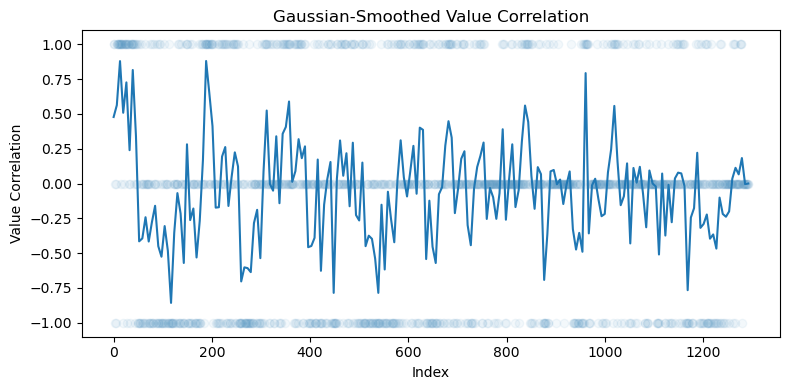

In [103]:
x_raw = animal_d_CdN.index.values.astype(float)
y_raw = animal_d_CdN['value_correlation'].values.astype(float)

x_smooth = np.linspace(x_raw.min(), x_raw.max(), 200)  # Smooth x-axis
bandwidth = 2  # Controls the width of the Gaussian kernel

y_smooth = []
for x0 in x_smooth:
    weights = norm.pdf(x_raw, loc=x0, scale=bandwidth)
    weights /= weights.sum()
    y_smooth.append(np.sum(weights * y_raw))

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=x_smooth, y=y_smooth)
plt.scatter(x_raw, y_raw, alpha=0.05, label='Raw Data')
plt.xlabel('Index')
plt.ylabel('Value Correlation')
plt.title('Gaussian-Smoothed Value Correlation')
plt.tight_layout()
plt.show()